In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

/tmp/user/20892/ipykernel_89106/2575619372.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 19.25, 10+1) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 25+1)

## Define the NP model in WC space

In [3]:
cvl = 10.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 1.0

## Compute number of samples to produce

In [4]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [5]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1230))

/home/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Smear samples with Gaussian resolution function
np.random.seed(4560)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

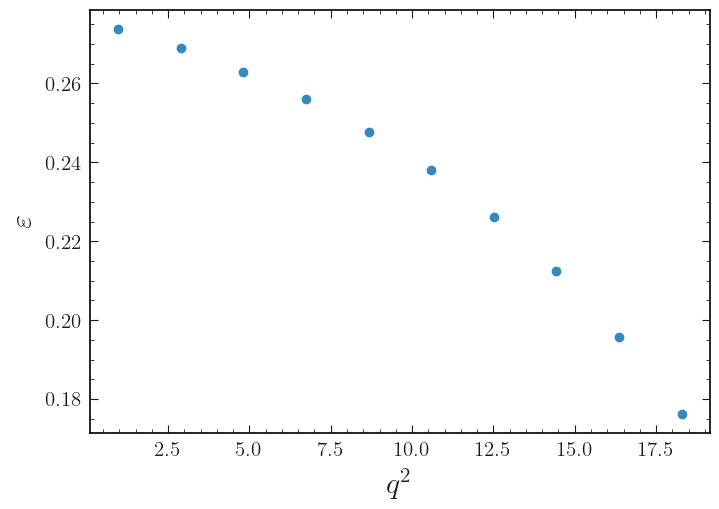

In [7]:
# plot efficiency
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [8]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=7890))

In [9]:
# Smear samples with Gaussian resolution function and apply efficiency
np.random.seed(1010)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

### Plot samples and calculate yields

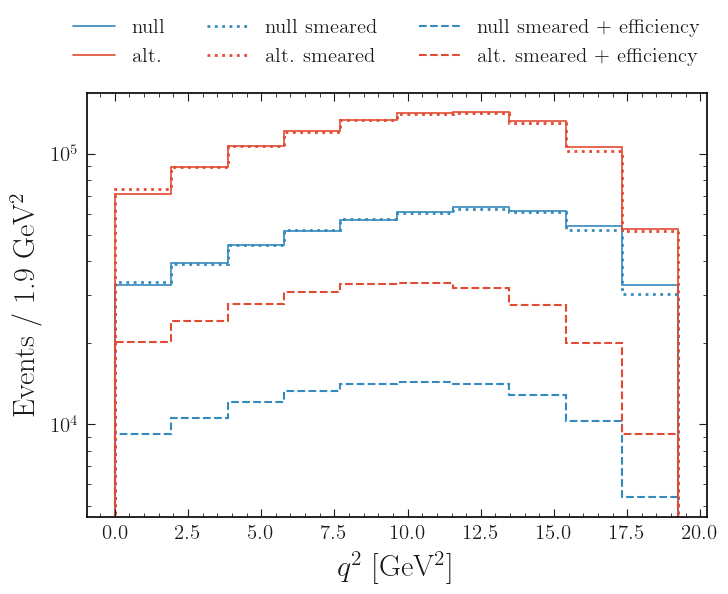

In [10]:
null_binned = np.histogram(null_samples, binning)[0]
alt_binned  = np.histogram(alt_samples,  binning)[0]

null_smeared_binned = np.histogram(null_samples_smeared, binning)[0]
alt_smeared_binned  = np.histogram(alt_samples_smeared,  binning)[0]

null_yields = np.histogram(null_samples_smeared, binning, weights = efficiency(null_samples_smeared))[0]
alt_yields  = np.histogram(alt_samples_smeared,  binning, weights = efficiency(alt_samples_smeared) )[0]

fig, ax = plt.subplots(1,1, sharex=True)

ax.stairs(null_binned, binning, color='C0', linewidth=1.2, linestyle='solid', label='null')
ax.stairs(alt_binned,  binning, color='C1', linewidth=1.2, linestyle='solid', label='alt.')
ax.stairs(null_smeared_binned, binning, color='C0', linewidth=2., linestyle='dotted', label='null smeared')
ax.stairs(alt_smeared_binned,  binning, color='C1', linewidth=2., linestyle='dotted', label='alt. smeared')
ax.stairs(null_yields, binning, label='null smeared + efficiency', color='C0', linewidth=1.5, linestyle='dashed')
ax.stairs(alt_yields,  binning, label='alt. smeared + efficiency', color='C1', linewidth=1.5, linestyle='dashed')

ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'Events / 1.9 GeV$^2$')

ax.set_yscale('log')
ax.set_yscale('log')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

file = '../results/ksnunu_data_sets.pdf'
plt.savefig(file)

plt.show()

In [11]:
print('# SM samples', SMsamples)
print('# SM yields', sum(null_yields))
print('# BSM samples', BSMBR/SMBR * SMsamples)
print('# BSM yields', sum(alt_yields))
print('ratio BSM/SM samples', BSMBR/SMBR)
print('ratio BSM/SM yields', sum(alt_yields)/sum(null_yields))

# SM samples 499239
# SM yields 116277.20307513168
# BSM samples 1096135.543636601
# BSM yields 258025.71745109055
ratio BSM/SM samples 2.195612809969976
ratio BSM/SM yields 2.2190567938271535


## Set up the mapping distribution

In [12]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [13]:
null = null_pred()
alt = alt_pred()

In [14]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()
t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()
t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [15]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded
Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.001429,-0.000783,-0.063255,0.000804,0.003936,-0.000127,0.013502,0.050576,0.001198,-0.003037,-0.063048,0.000579,0.001062,0.012997,0.003999,0.013892,0.001080,0.001477,-0.019931
1,-0.000783,0.066039,0.376485,-0.001003,-0.001022,-0.019515,0.021904,0.149820,-0.003431,0.014736,0.187574,-0.000915,-0.003302,-0.073291,-0.008298,-0.054909,-0.002483,-0.003942,0.050023
2,-0.063255,0.376485,7.817416,-0.024235,-0.168423,-0.088139,-0.580625,-1.597669,-0.050883,0.092806,4.035921,-0.008688,-0.105557,-1.991418,-0.192241,-1.528172,-0.042420,0.023533,1.301351
3,0.000804,-0.001003,-0.024235,0.000880,0.003617,-0.003752,0.006871,0.027338,0.001350,-0.003249,-0.063462,0.000831,0.000335,-0.005884,0.004216,0.004411,0.001141,0.003286,-0.010230
4,0.003936,-0.001022,-0.168423,0.003617,0.028578,0.049568,0.057137,0.276662,0.006094,-0.011900,-0.335306,0.003475,0.003863,0.010220,0.019150,0.034429,0.005169,0.013039,-0.052845
5,-0.000127,-0.019515,-0.088139,-0.003752,0.049568,0.546352,0.078496,0.579064,-0.001101,-0.009386,0.020145,-0.002393,0.008470,0.179110,-0.011384,0.026917,-0.001420,-0.010562,-0.001050
6,0.013502,0.021904,-0.580625,0.006871,0.057137,0.078496,0.243404,1.237767,0.009733,-0.015594,-0.604531,0.004246,0.016193,0.225147,0.038735,0.179226,0.009345,0.001337,-0.228884
7,0.050576,0.149820,-1.597669,0.027338,0.276662,0.579064,1.237767,7.096278,0.037091,-0.053165,-2.230731,0.016978,0.073204,0.981699,0.158164,0.722044,0.037040,-0.009231,-0.950141
8,0.001198,-0.003431,-0.050883,0.001350,0.006094,-0.001101,0.009733,0.037091,0.002539,-0.006929,-0.135258,0.001352,0.000671,-0.006462,0.007119,0.009803,0.001911,0.005508,-0.018278
9,-0.003037,0.014736,0.092806,-0.003249,-0.011900,-0.009386,-0.015594,-0.053165,-0.006929,0.046410,0.409080,-0.003307,-0.000765,0.028532,-0.016105,-0.012694,-0.004814,-0.014018,0.057059


In [16]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,),  'bounds': ((6., 16.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

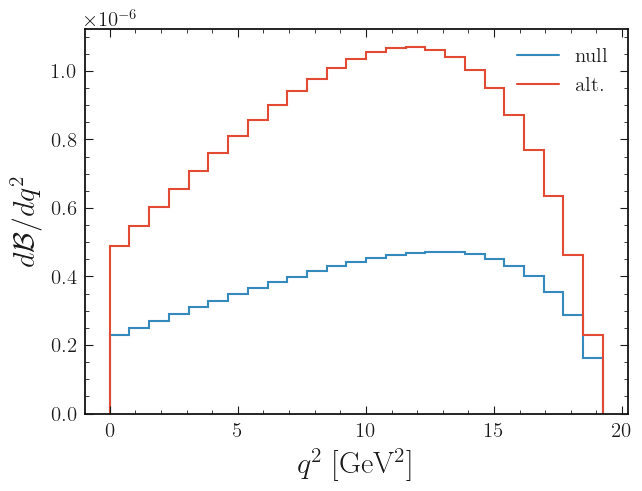

In [17]:
pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Target bins'>)

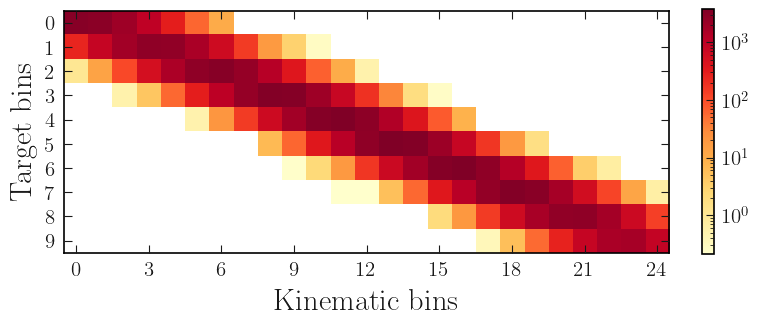

In [18]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [19]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [9224.389990441818,
      10550.960043761912,
      12078.891022899326,
      13313.054695740611,
      14152.050504182705,
      14366.893736566963,
      14065.25239944135,
      12875.717368726997,
      10268.352182791088,
      5381.641130578908],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [96.04368792607778,
        102.71786623446728,
        109.90400822035258,
        115.38221134880632,
        118.96239113342799,
        119.8619778602329,
        118.59701682353291,
        113.47121823937115,
        101.33287809388959,
        73.35966964605899]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [20]:
modifier.save('ksnunu_model.json', model.spec, [cmod], alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [21]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

# for i in range(3, 19):
#     fixed[model.config.par_map[f'FFKs_decorrelated[{i}]']['slice']] = [True]


pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.0205283
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0352008
W MnPosDef Matrix forced pos-def by adding to diagonal 0.27059


{'cvl': array([10.69232556,  0.02514406]),
 'cvr': array([4.22533185, 0.06985306]),
 'csl': array([0.03141376, 9.41016696]),
 'csr': array([0.001, 0.   ]),
 'ctl': array([0.96541843, 0.00589448]),
 'FFKs_decorrelated[0]': array([0.18695153, 0.01543013]),
 'FFKs_decorrelated[1]': array([0.01402232, 0.03715041]),
 'FFKs_decorrelated[2]': array([0.06919179, 0.04532783]),
 'FFKs_decorrelated[3]': array([0.0666621 , 0.13401992]),
 'FFKs_decorrelated[4]': array([0.04816612, 0.06602808]),
 'FFKs_decorrelated[5]': array([-0.0018322 ,  0.48274627]),
 'FFKs_decorrelated[6]': array([0.00225147, 0.09105337]),
 'FFKs_decorrelated[7]': array([-0.00968592,  0.08987162]),
 'FFKs_decorrelated[8]': array([0.00148919, 0.05886949]),
 'FFKs_decorrelated[9]': array([-0.01536424,  0.04124494]),
 'FFKs_decorrelated[10]': array([0.00221012, 0.16919489]),
 'FFKs_decorrelated[11]': array([-0.01618992,  0.03517801]),
 'FFKs_decorrelated[12]': array([0.02000334, 0.05028533]),
 'FFKs_decorrelated[13]': array([0.001

In [22]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 10.692325560589014,
 'cvr': 4.2253318481508435,
 'csl': 0.031413758196779974,
 'csr': 0.001,
 'ctl': 0.9654184301059409,
 'FFKs[0]': 0.3566243616173182,
 'FFKs[1]': -1.0639100688743262,
 'FFKs[2]': 3.391445335904471,
 'FFKs[3]': 0.33940828761940317,
 'FFKs[4]': -1.1658712345234767,
 'FFKs[5]': 2.3574758855235185,
 'FFKs[6]': 0.2220455338470231,
 'FFKs[7]': 0.2161716324461885,
 'FFKs[8]': 1.219134287449856,
 'FFKs[9]': 0.5622320690876079,
 'FFKs[10]': 0.9326324202536201,
 'FFKs[11]': 0.31785931353981434,
 'FFKs[12]': -0.9705076163213765,
 'FFKs[13]': 1.9383457062920642,
 'FFKs[14]': 0.5750444775996439,
 'FFKs[15]': 1.5595167060389972,
 'FFKs[16]': 0.6168472060877299,
 'FFKs[17]': 0.9738012184642889,
 'FFKs[18]': 1.943650499577947,
 'mu': 1.0,
 'stat': [0.9973033633787455,
  1.0040409919110973,
  1.0020902816369084,
  0.9965903449275433,
  0.9974577891906756,
  1.0014392726930765,
  1.0020704180457272,
  0.9999223348066347,
  0.9984202221758806,
  1.0009541064783456]}

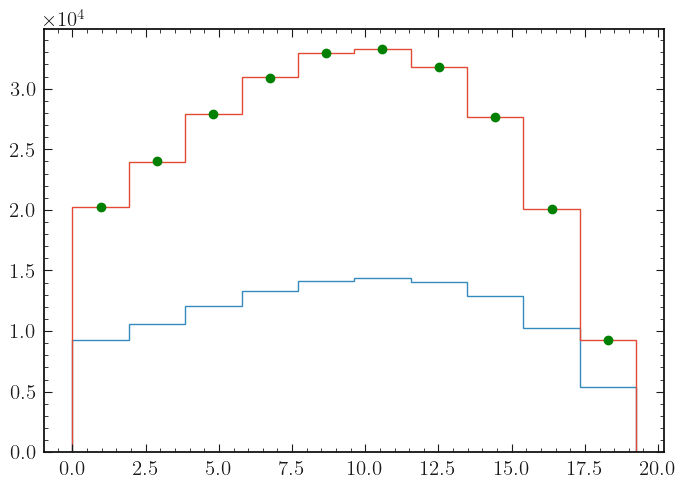

In [23]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')